# The final project

The telecommunications operator wants to learn how to predict customer churn. If it turns out that a user is planning to leave, they will be offered promotional codes and special conditions. The operator's team has gathered personal data about some clients, information about their tariffs, and contracts.

#### Service Description
The operator provides two main types of services:

 - **Landline telephone communication**: It's possible to connect a telephone apparatus to multiple lines simultaneously.

 - **Internet**: Connection can be of two types: through a telephone line (DSL - digital subscriber line) or via fiber optic cable.

The following services are also available:

 - Internet security: antivirus (DeviceProtection) and unsafe website blocking (OnlineSecurity).
 - Dedicated technical support line (TechSupport).
 - Cloud file storage for data backup (OnlineBackup).
 - Streaming television (StreamingTV) and movie catalog (StreamingMovies).

Customers can pay for the services every month or sign contracts for 1-2 years. Various payment methods are available, including the option to receive an electronic receipt.

The goal of the project is to train a model that will predict the possibility of a customer leaving the company. The model should achieve an AUC-ROC score above 0.85.

## Preliminary Data Analysis 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             roc_curve,
                             confusion_matrix
)    
from sklearn.model_selection import (GridSearchCV, 
                                     RandomizedSearchCV,
                                     train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler
)
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 100723

In [2]:
#Loading the data
contract = pd.read_csv('/Users/mojseenkodenis/Desktop/神戸大学/プログラミング/Итоговый проект, Яндекс/contract_new.csv')
internet = pd.read_csv('/Users/mojseenkodenis/Desktop/神戸大学/プログラミング/Итоговый проект, Яндекс/internet_new.csv')
personal = pd.read_csv('/Users/mojseenkodenis/Desktop/神戸大学/プログラミング/Итоговый проект, Яндекс/personal_new.csv')
phone = pd.read_csv('/Users/mojseenkodenis/Desktop/神戸大学/プログラミング/Итоговый проект, Яндекс/phone_new.csv')

In [3]:
files = ['/Users/mojseenkodenis/Desktop/神戸大学/プログラミング/Итоговый проект, Яндекс/contract_new.csv', 
         '/Users/mojseenkodenis/Desktop/神戸大学/プログラミング/Итоговый проект, Яндекс/internet_new.csv', 
         '/Users/mojseenkodenis/Desktop/神戸大学/プログラミング/Итоговый проект, Яндекс/personal_new.csv', 
         '/Users/mojseenkodenis/Desktop/神戸大学/プログラミング/Итоговый проект, Яндекс/phone_new.csv']
dataframes = {}

for file_name in files:
    df_name = os.path.splitext(os.path.basename(file_name))[0]  
    dataframes[df_name] = pd.read_csv(file_name)

for df_name, df in dataframes.items():
    print(f"--- {df_name} ---")
    print(df.head())
    print()

--- contract_new ---
   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5  

--- internet_new ---
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE       

In [4]:
for df_name, df in dataframes.items():
    print(f"--- {df_name} ---")
    print(df.info())
    print()

--- contract_new ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

--- internet_new ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-

There are 7043 users in the data, but in the 'internet' and 'phone' datasets, there are fewer data points (5517 and 6361) because not all users subscribed to additional services or both internet and phone communication. Consequently, when merging the datasets, gaps in the data are formed.

In [5]:
for df_name, df in dataframes.items():
    print(f"--- {df_name} ---")
    print(df.describe())
    print()

--- contract_new ---
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

--- internet_new ---
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785  

--- personal_new ---
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0

In [6]:
#Changing column TotalCharges to float
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [7]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [8]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)
contract['TotalCharges'].isna().sum()

0

In [9]:
#Changing column BeginDate to datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

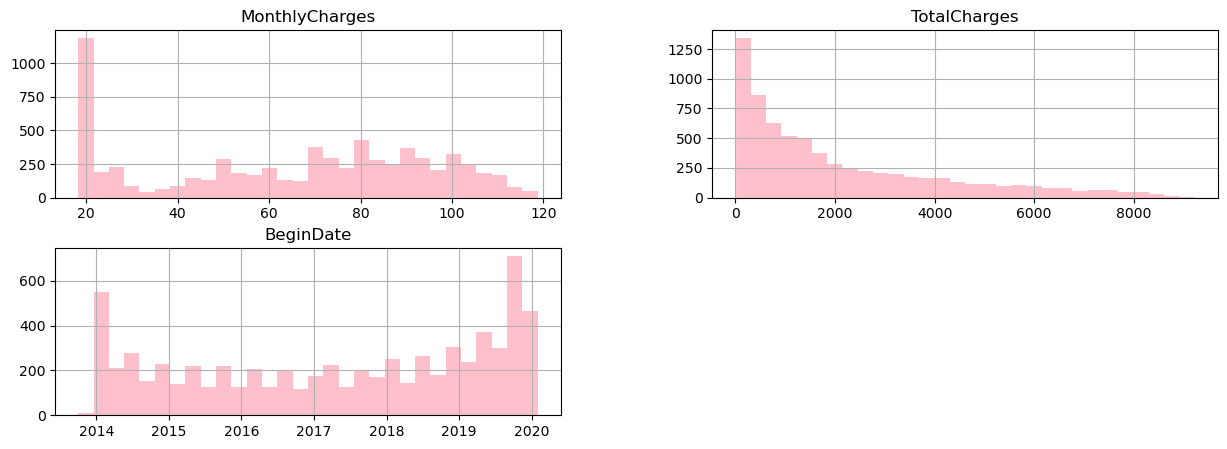

In [10]:
#Examining the distribution of features
contract[['MonthlyCharges', 'TotalCharges', 'BeginDate']].hist(color='pink', figsize=(15, 5), bins=30);

In [11]:
#Checking for the presence of duplicates in the data
for df_name, df in dataframes.items():
    print(f"--- {df_name} ---")
    print(f'Number of duplicates in {df_name}: {df.duplicated().sum()}')
    print()

--- contract_new ---
Number of duplicates in contract_new: 0

--- internet_new ---
Number of duplicates in internet_new: 0

--- personal_new ---
Number of duplicates in personal_new: 0

--- phone_new ---
Number of duplicates in phone_new: 0



In [12]:
#Checking for the presence of missing values in the data
for df_name, df in dataframes.items():
    print(f"--- {df_name} ---")
    print(f'Number of missing values in {df_name}: {df.isna().sum()}')
    print()

--- contract_new ---
Number of missing values in contract_new: customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

--- internet_new ---
Number of missing values in internet_new: customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

--- personal_new ---
Number of missing values in personal_new: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

--- phone_new ---
Number of missing values in phone_new: customerID       0
MultipleLines    0
dtype: int64



In [13]:
#Change the names so that they all start with a capital letter
contract = contract.rename(columns={'customerID':'CustomerID'})
internet = internet.rename(columns={'customerID':'CustomerID'})
personal = personal.rename(columns={'gender':'Gender', 'customerID':'CustomerID'})
phone = phone.rename(columns={'customerID':'CustomerID'})

In [14]:
datasets = [contract, internet, personal, phone]
for x in datasets:
    print(x.columns.values)

['CustomerID' 'BeginDate' 'EndDate' 'Type' 'PaperlessBilling'
 'PaymentMethod' 'MonthlyCharges' 'TotalCharges']
['CustomerID' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies']
['CustomerID' 'Gender' 'SeniorCitizen' 'Partner' 'Dependents']
['CustomerID' 'MultipleLines']


In [15]:
#Merging tables
data = contract.merge(internet, how='left', on='CustomerID')\
               .merge(personal, how='left', on='CustomerID')\
               .merge(phone, how='left', on='CustomerID')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

In [17]:
data['CustomerID'].is_unique

True

In [18]:
#Making CustomerID index
data = data.set_index('CustomerID')

In [19]:
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [20]:
data.isna().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

After the merge, missing values appeared in the columns of the 'internet' and 'phone' datasets. Most likely, these are users who did not subscribe to the services. 

In [21]:
#Checking if all 1526 missing values belong to the same users
data[data['InternetService'].isna() & 
     data['OnlineSecurity'].isna() & 
     data['OnlineBackup'].isna() & 
     data['InternetService'].isna() &
     data['DeviceProtection'].isna() &
     data['TechSupport'].isna() &
     data['StreamingTV'].isna() &
     data['StreamingMovies'].isna() ]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,
7469-LKBCI,2018-10-01,No,Two year,No,Credit card (automatic),18.95,312.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,No,No
8191-XWSZG,2015-10-01,No,One year,No,Mailed check,20.65,1106.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,No,No,No
1680-VDCWW,2019-02-01,No,One year,No,Bank transfer (automatic),19.80,237.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,No,No
1066-JKSGK,2019-11-01,No,Month-to-month,No,Mailed check,20.15,61.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,No,No
7310-EGVHZ,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,22.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807-IZYOZ,2015-11-01,No,Two year,No,Bank transfer (automatic),20.65,1053.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,No,No,No
9710-NJERN,2016-11-01,No,Two year,No,Mailed check,20.15,785.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,No,No,No
9837-FWLCH,2019-02-01,No,Month-to-month,Yes,Electronic check,19.20,246.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No


All missing values belong to the same users, so it is possible to change those values to No

In [22]:
for column in ('InternetService',
               'OnlineSecurity',  
               'DeviceProtection', 
               'TechSupport', 
               'StreamingTV', 
               'StreamingMovies', 
               'OnlineBackup',
               'MultipleLines'):
    data[column] = data[column].fillna('No') 

In [23]:
data.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

In [24]:
data.head(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Fiber optic,No,No,Yes,No,Yes,Yes,Female,0,No,No,Yes
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Fiber optic,No,Yes,No,No,Yes,No,Male,0,No,Yes,Yes
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,DSL,Yes,No,No,No,No,No,Female,0,No,No,No
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Fiber optic,No,No,Yes,Yes,Yes,Yes,Female,0,Yes,No,Yes


Let's create a few new features:

 - "Left": If the user has left, then 1; if they are staying, then 0
 - "Total Days": The total number of days the person has been or was a customer of the company

In [25]:
data['Left'] = (data['EndDate'] != 'No').astype(int)

In [26]:
#Replacing "No" in the "EndDate" column with the dataset extraction date (2020-02-01).
data['EndDate'] = data['EndDate'].replace(['No'], ['2020-02-01'])
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')

In [27]:
data['TotalDays'] = (data['EndDate'] - data['BeginDate']).dt.days

In [28]:
#Deleting columns BeginDate and EndDate
data = data.drop(['BeginDate', 'EndDate'], axis=1)

In [29]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,Left,TotalDays
CustomerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,0,31
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,0,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,0,153


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   InternetService   7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Gender            7043 non-null   object 
 13  SeniorCitizen     7043 non-null   int64  
 14  Partner           7043 non-null   object 
 15  Dependents        7043 non-null   object 
 16  MultipleLines     7043 non-null 

### Data analysis

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Left', 'TotalDays']


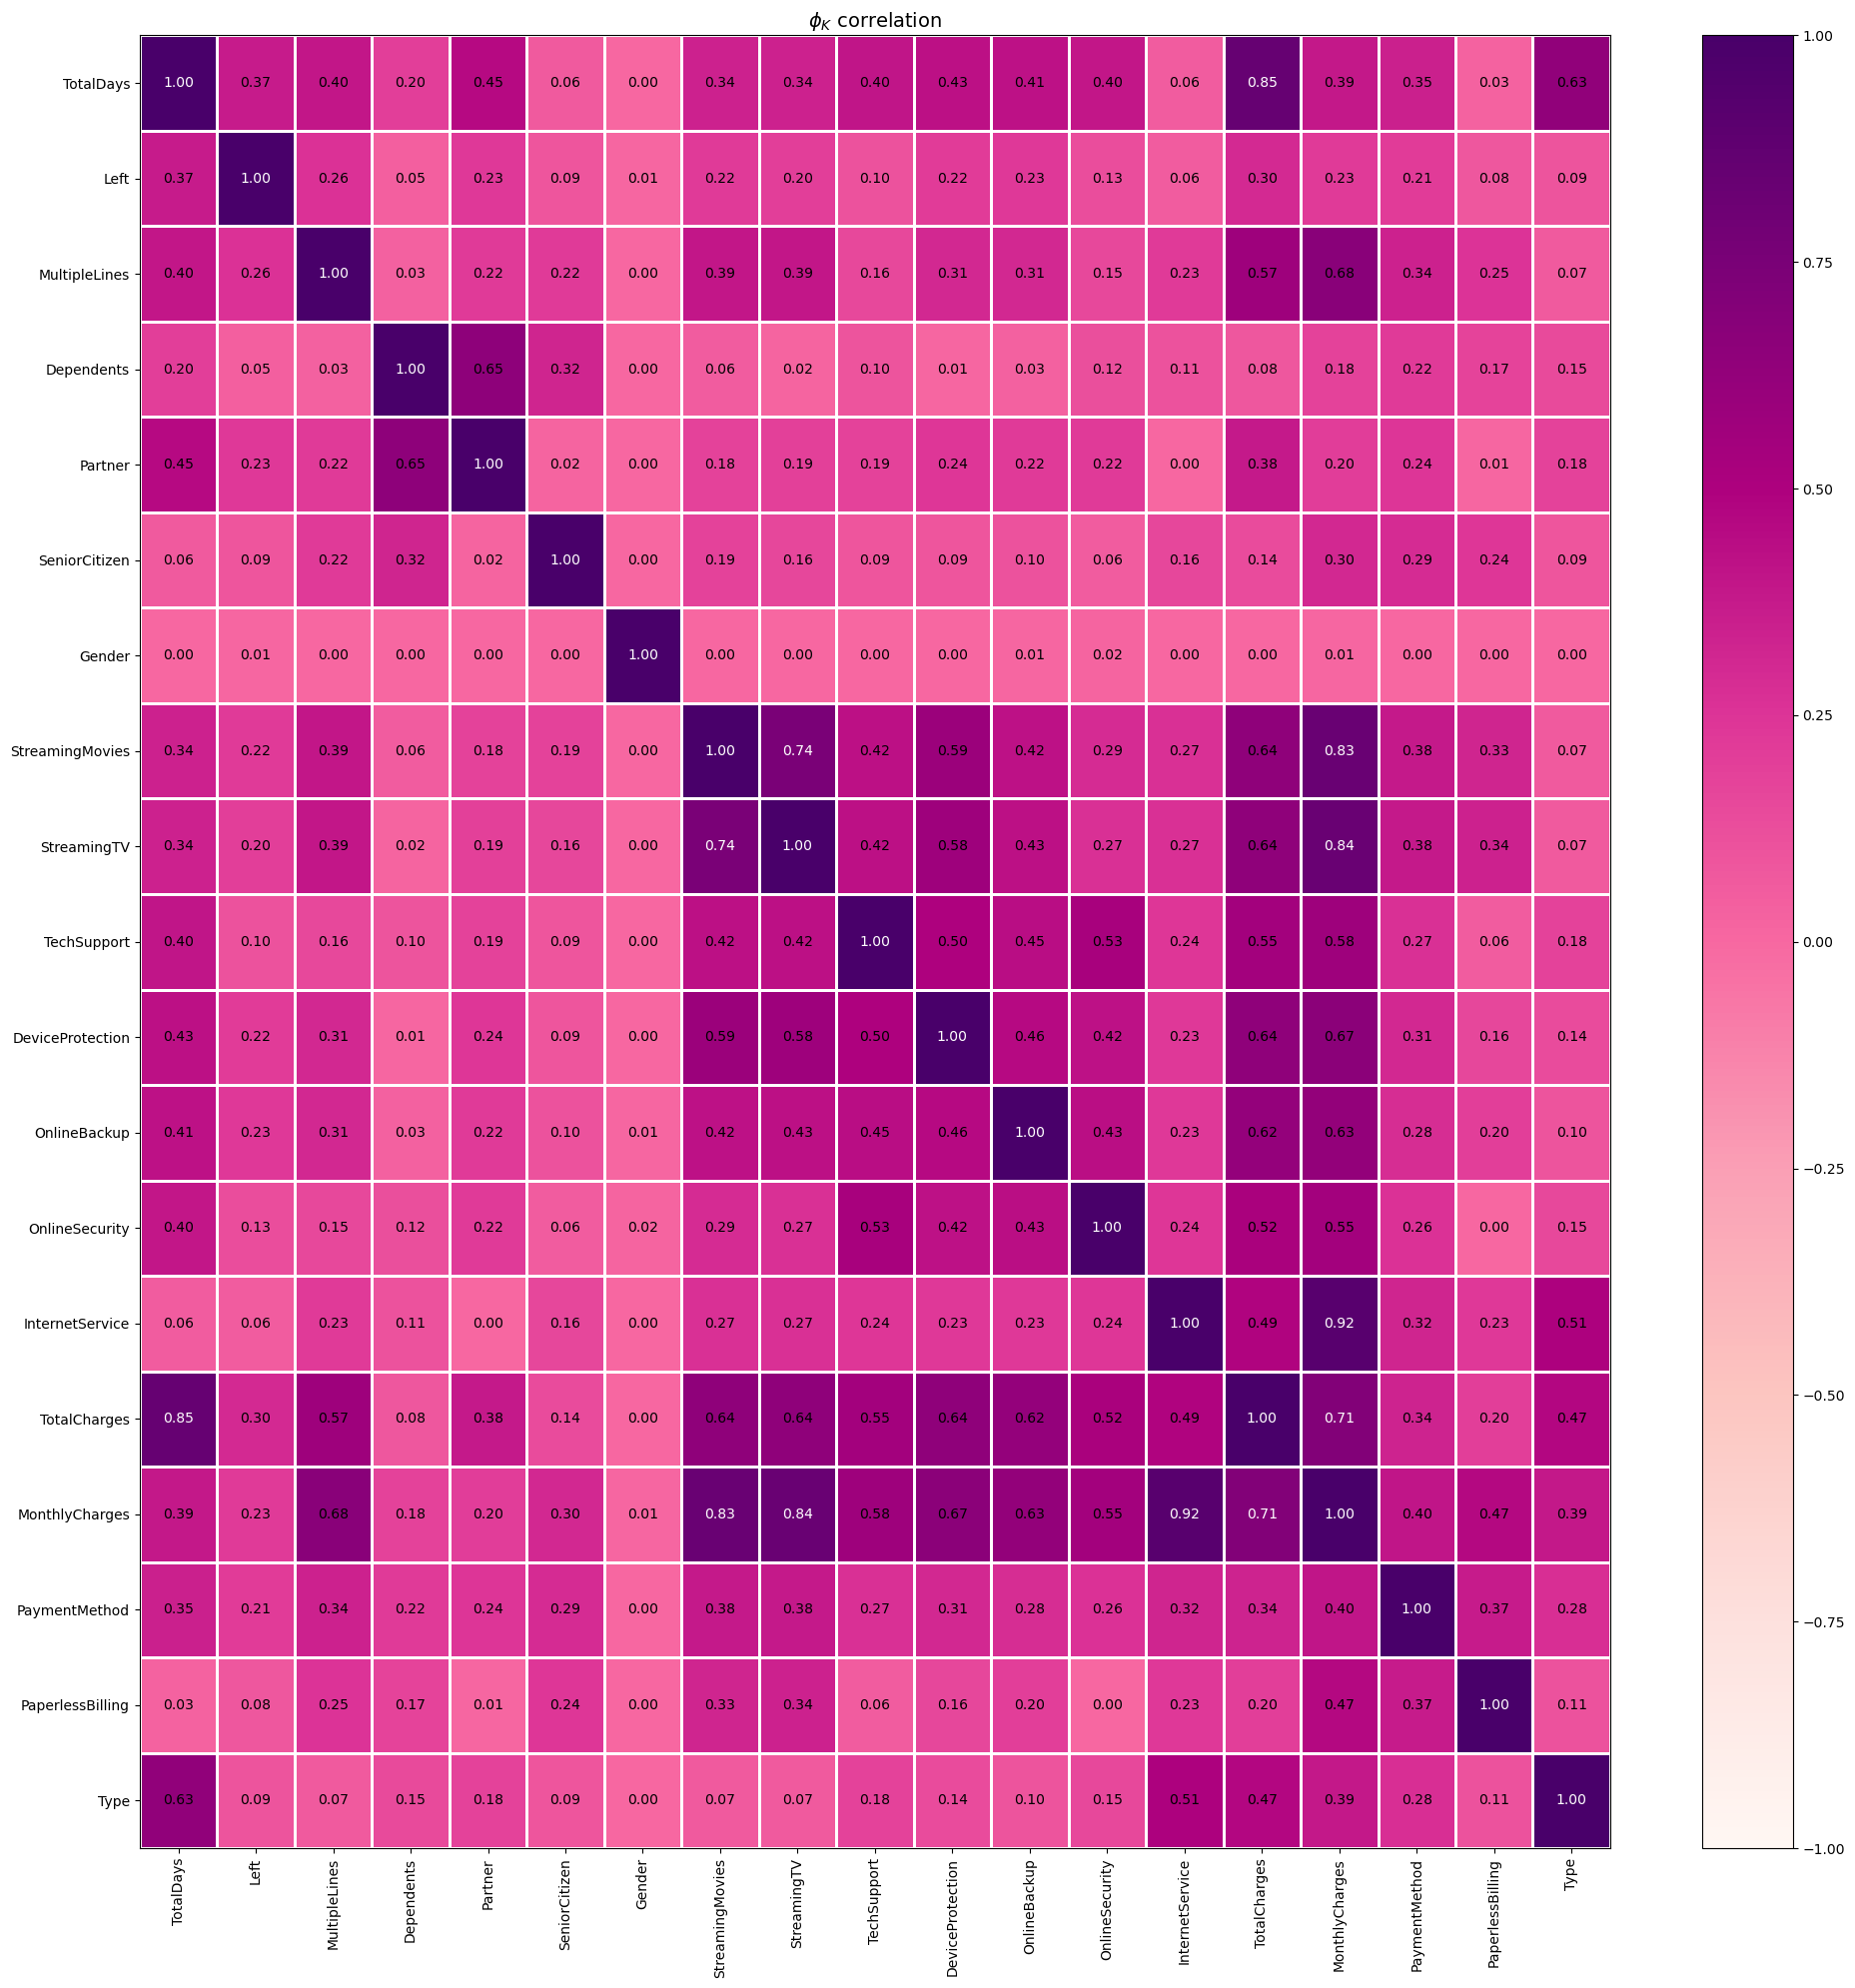

In [31]:
#Looking at the correlation between the columns
phik_correlation = data.phik_matrix()
plot_correlation_matrix(phik_correlation.values,
                        x_labels=phik_correlation.columns,
                        y_labels=phik_correlation.index,
                        title='$\phi_K$ correlation',
                        figsize=(20, 20),
                        color_map='RdPu')

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Left', 'TotalDays']


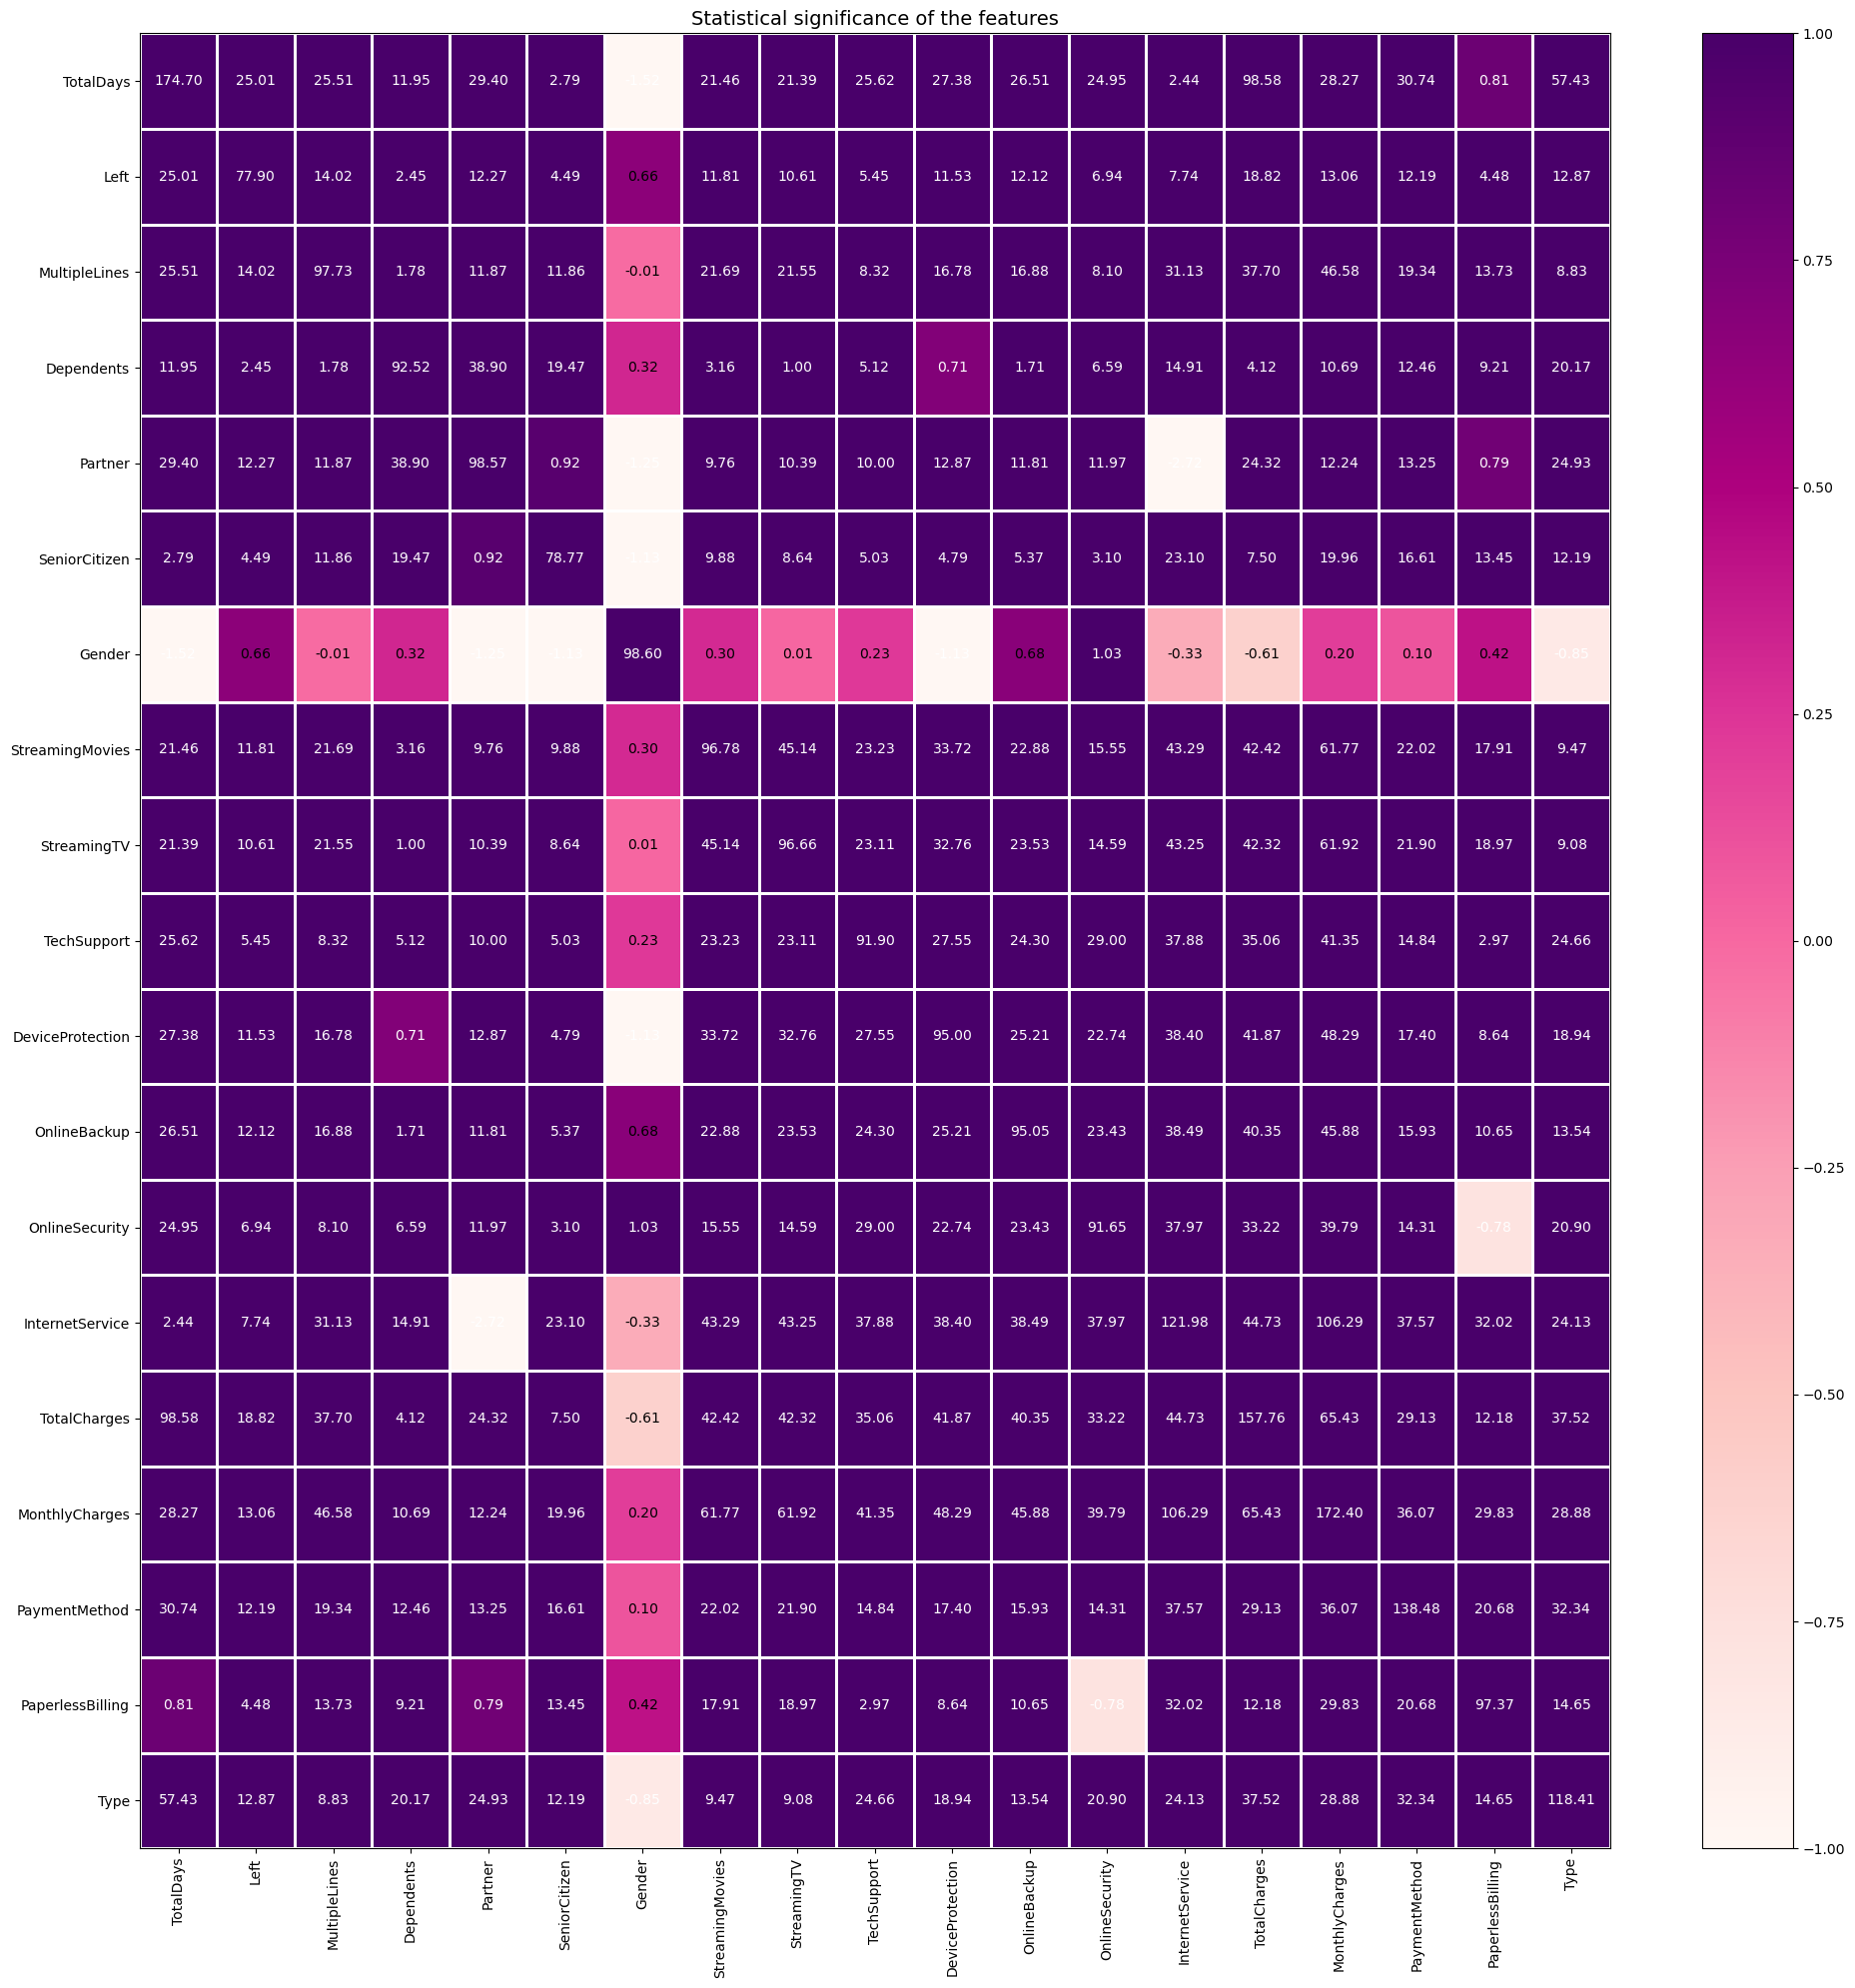

In [32]:
#Examening the statistical significance of the features
significance = data.significance_matrix()
plot_correlation_matrix(significance.values, 
                        x_labels=significance.columns, 
                        y_labels=significance.index, 
                        title='Statistical significance of the features', 
                        figsize=(20, 20),
                        color_map='RdPu')

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Left', 'TotalDays']


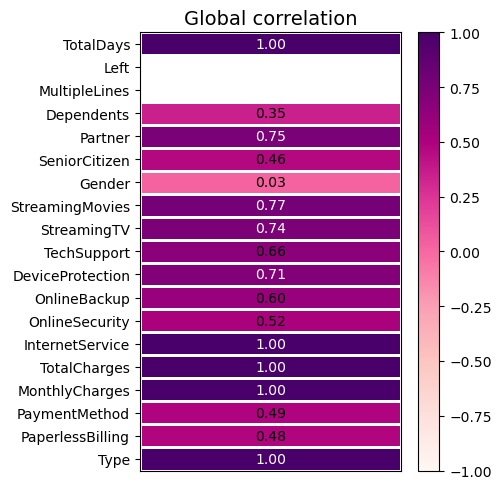

In [33]:
global_correlation, global_labels = data.global_phik()

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], 
                        y_labels=global_labels, 
                        title='Global correlation', 
                        figsize=(5, 5),
                        color_map='RdPu')

The correlation analysis has shown that some features have a relatively high level of correlation:

 - "TotalDays" is strongly correlated with "TotalCharges," which is logical because the longer customers are with the company, the more they pay
 - "MonthlyCharges" and "TotalCharges" have a high level of correlation with additional services
 - Moreover, the additional services have a moderate level of correlation with each other

"MonthlyCharges" and "TotalCharges" exhibit a moderate to high level of correlation and essentially convey the same information. Therefore, it might be a good idea to remove the "TotalCharges" column.

All columns exhibit a high level of statistical significance except for the "Gender" column, so it's possible that this feature might not play a significant role in model training.

The overall correlation analysis indicates that "TotalDays," "InternetService," "TotalCharges," and "MonthlyCharges" have the highest correlation levels compared to other columns. In the case of training a logistic regression model, multicollinearity might affect the results. However, for other models, multicollinearity should not pose a significant issue.

In [34]:
data = data.drop('TotalCharges', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   InternetService   7043 non-null   object 
 5   OnlineSecurity    7043 non-null   object 
 6   OnlineBackup      7043 non-null   object 
 7   DeviceProtection  7043 non-null   object 
 8   TechSupport       7043 non-null   object 
 9   StreamingTV       7043 non-null   object 
 10  StreamingMovies   7043 non-null   object 
 11  Gender            7043 non-null   object 
 12  SeniorCitizen     7043 non-null   int64  
 13  Partner           7043 non-null   object 
 14  Dependents        7043 non-null   object 
 15  MultipleLines     7043 non-null   object 
 16  Left              7043 non-null 

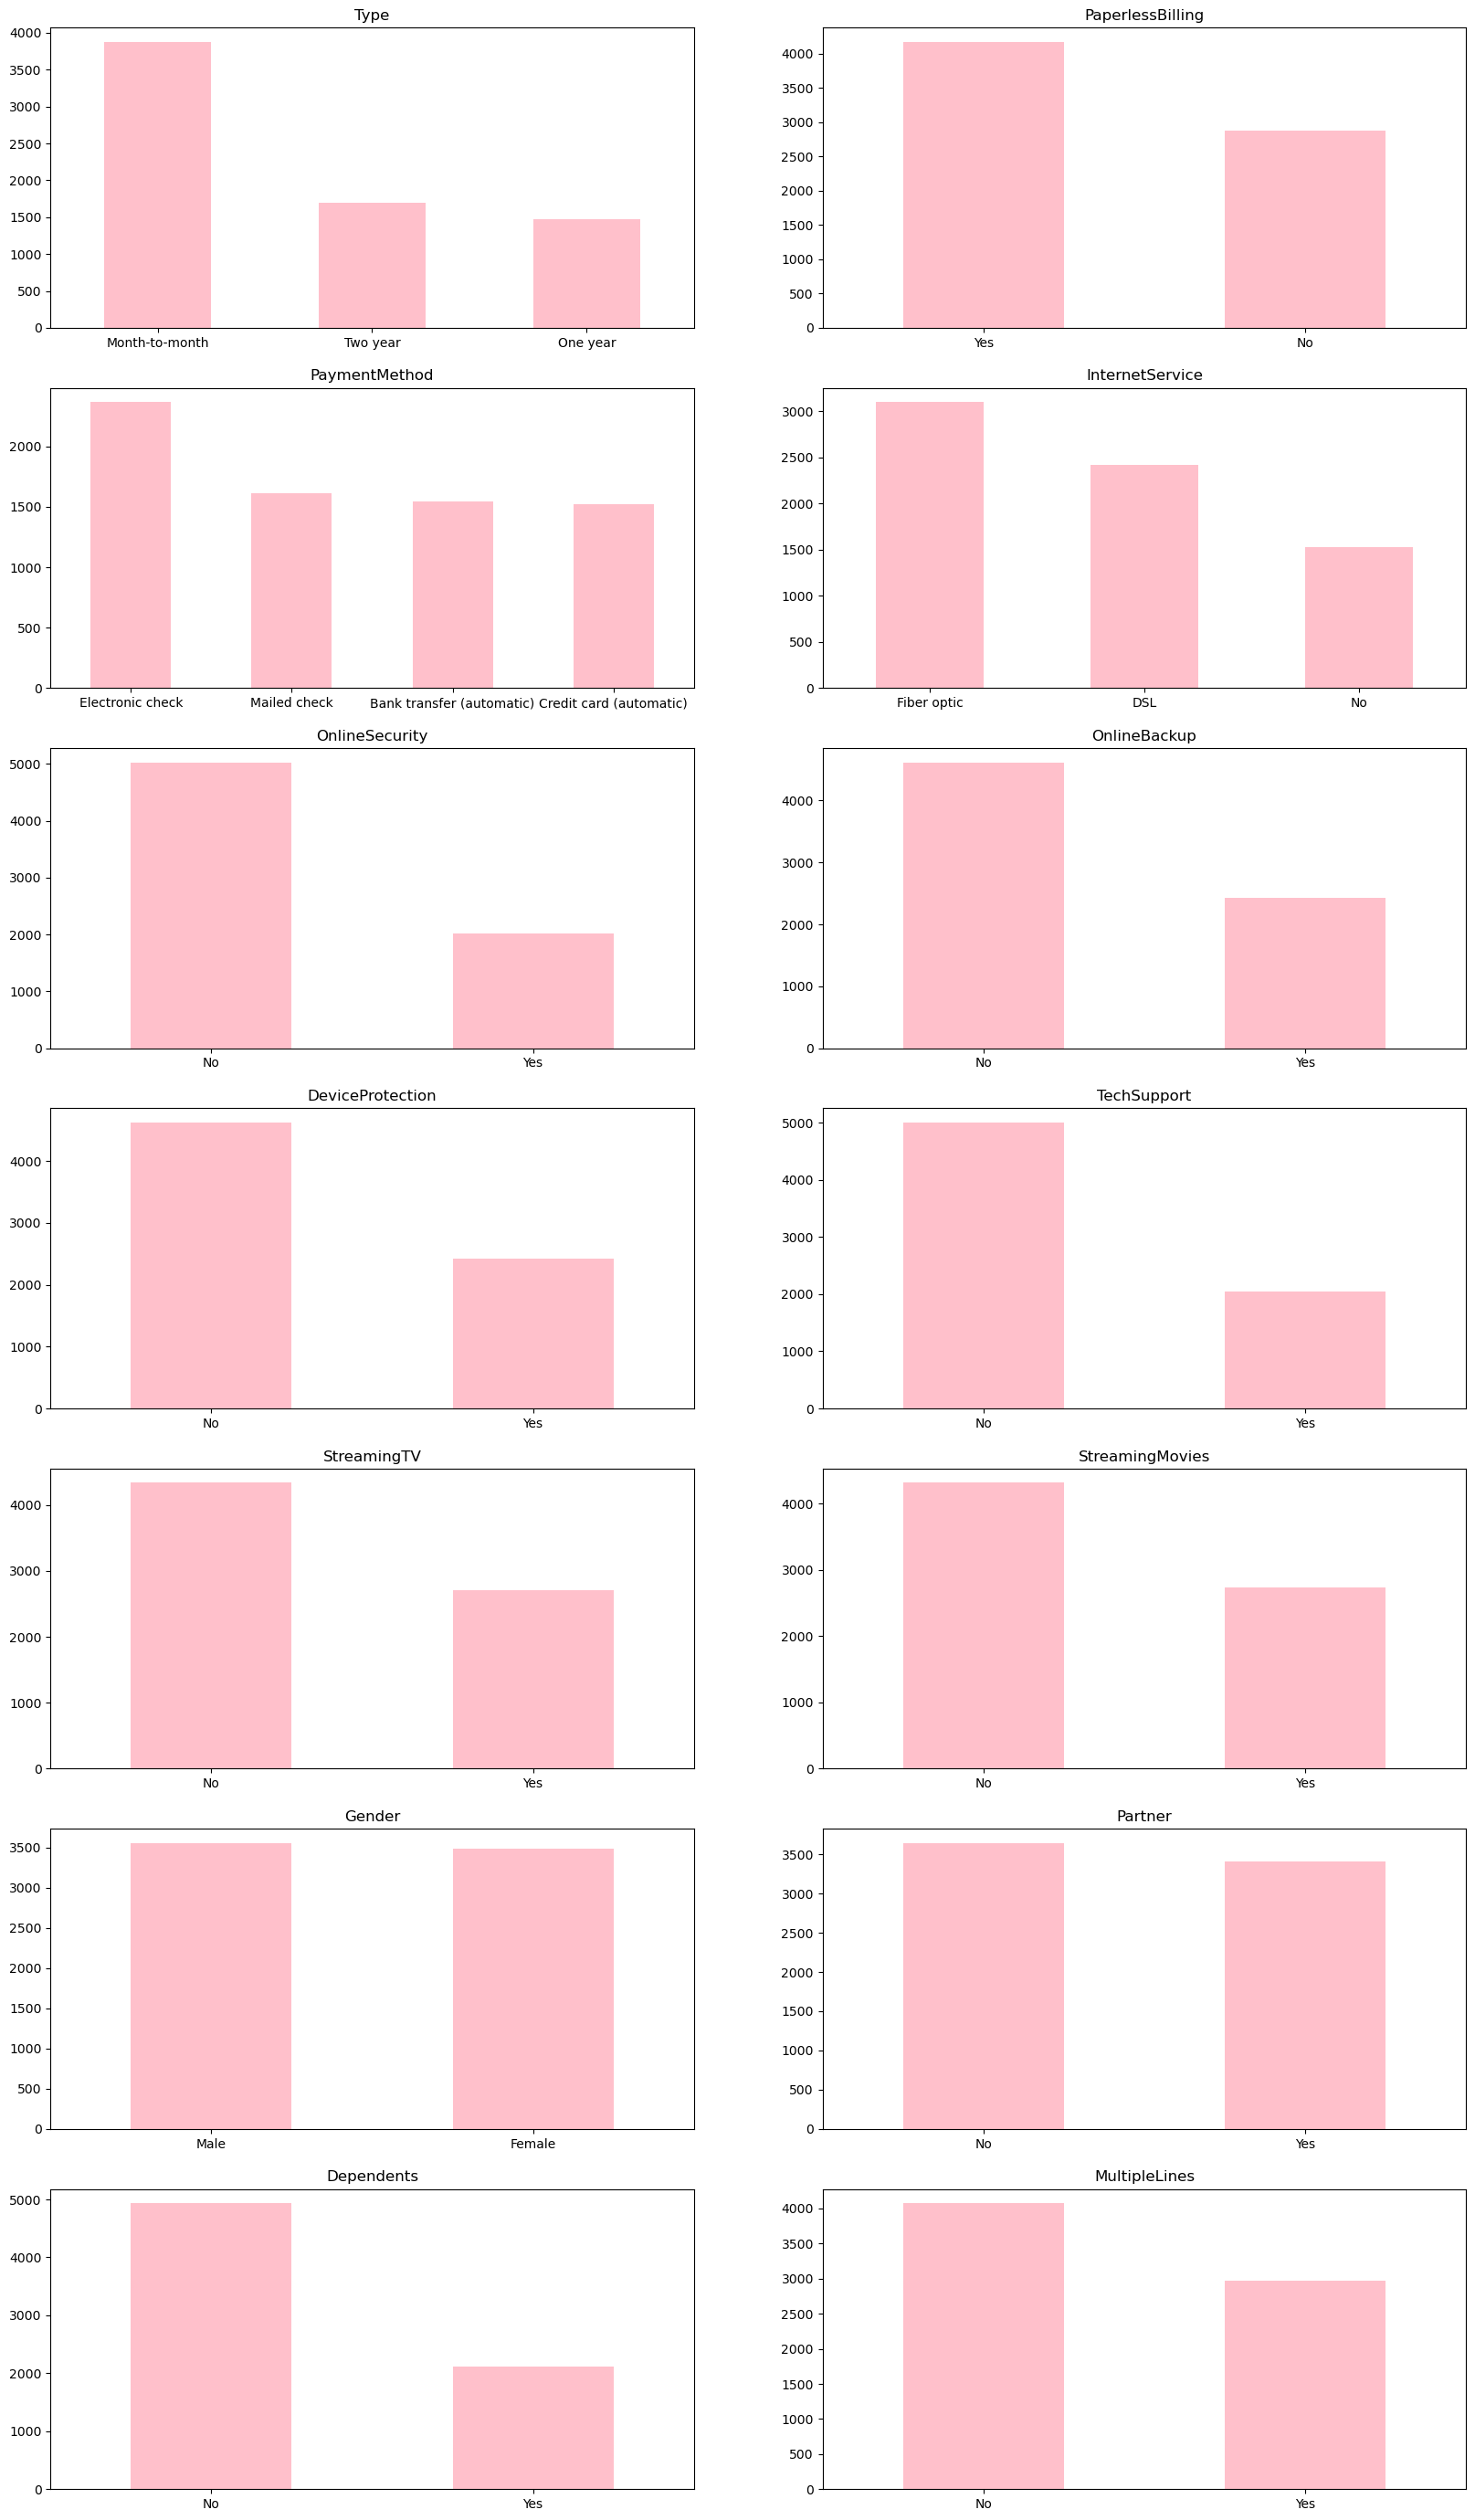

In [35]:
#Distribution of categorical features
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

cols = 2
rows = int(np.ceil(len(categorical_columns) / cols))

plt.figure(figsize=(20, 35))

for idx, column in enumerate(categorical_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    
    data[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0,
        color='pink'
    )
        
plt.show()

Based on the distribution of categorical features, it is possible to observe the following:

 - A significant portion of customers pay for internet services on a monthly basis
 - Users prefer electronic payment methods (electronic check, automatic bank withdrawal, and credit cards)
 - More customers use internet services via a telephone line
 - The number of men and women is approximately equal, as well as individuals with and without dependents
 - Additional services are not very popular among customers

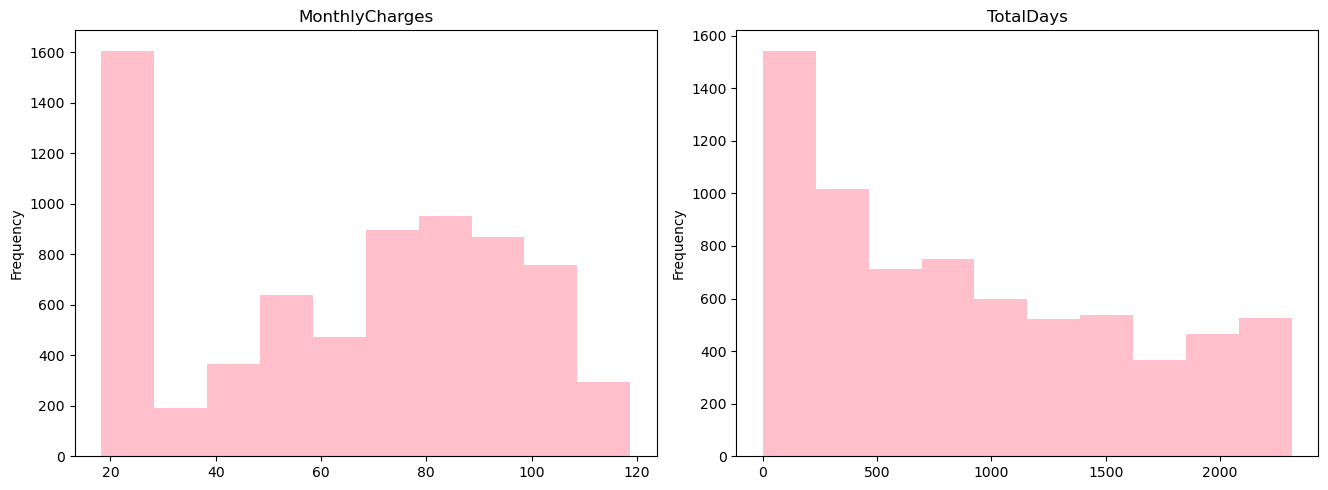

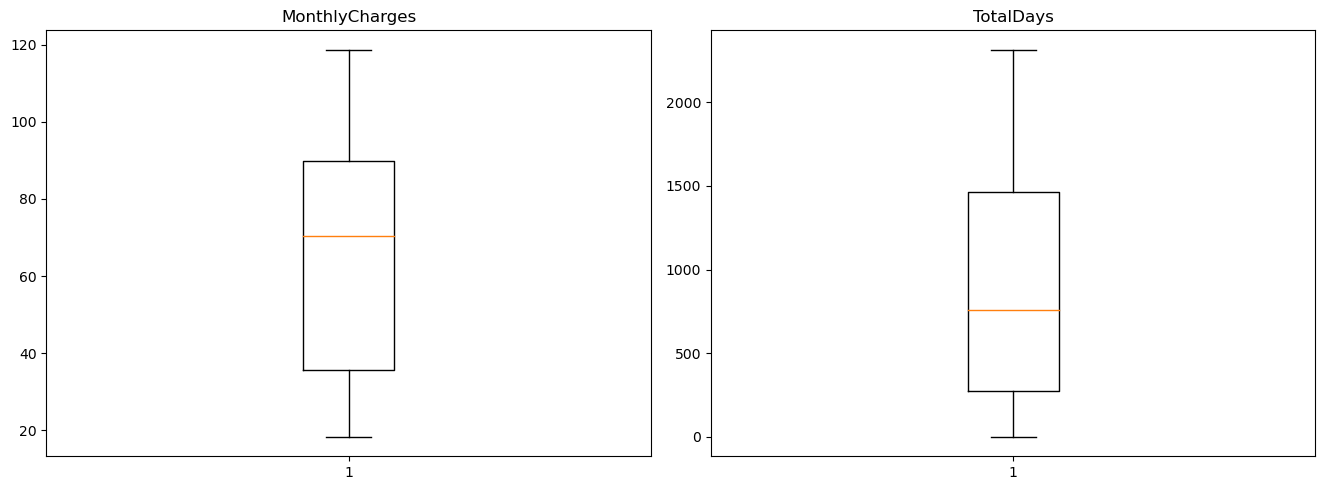

In [36]:
#Distribution of numeric features
numerical_columns = ['MonthlyCharges', 'TotalDays']

cols = 3
rows = int(np.ceil(len(numerical_columns) / cols))

plt.figure(figsize=(20, 5))

for idx, column in enumerate(numerical_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    
    data[column].plot(
        kind='hist', 
        title=column, 
        ax=ax,
        rot=0,
        color='pink'
    )
plt.tight_layout()    
plt.show()

plt.figure(figsize=(20, 5))
for idx, column in enumerate(numerical_columns):
    ax = plt.subplot(rows, cols, idx + 1)  
    plt.boxplot(data[column])
    plt.title(column)
plt.tight_layout()        
plt.show()

The columns "MonthlyCharges" and "TotalDays" have non-normal distributions: a significant number of users pay between 20 and 30 for internet services per month. Additionally, the company has a substantial number of long-term customers, but there is also a noticeable increase in new customers.

Furthermore, there are no outliers in the numerical features.

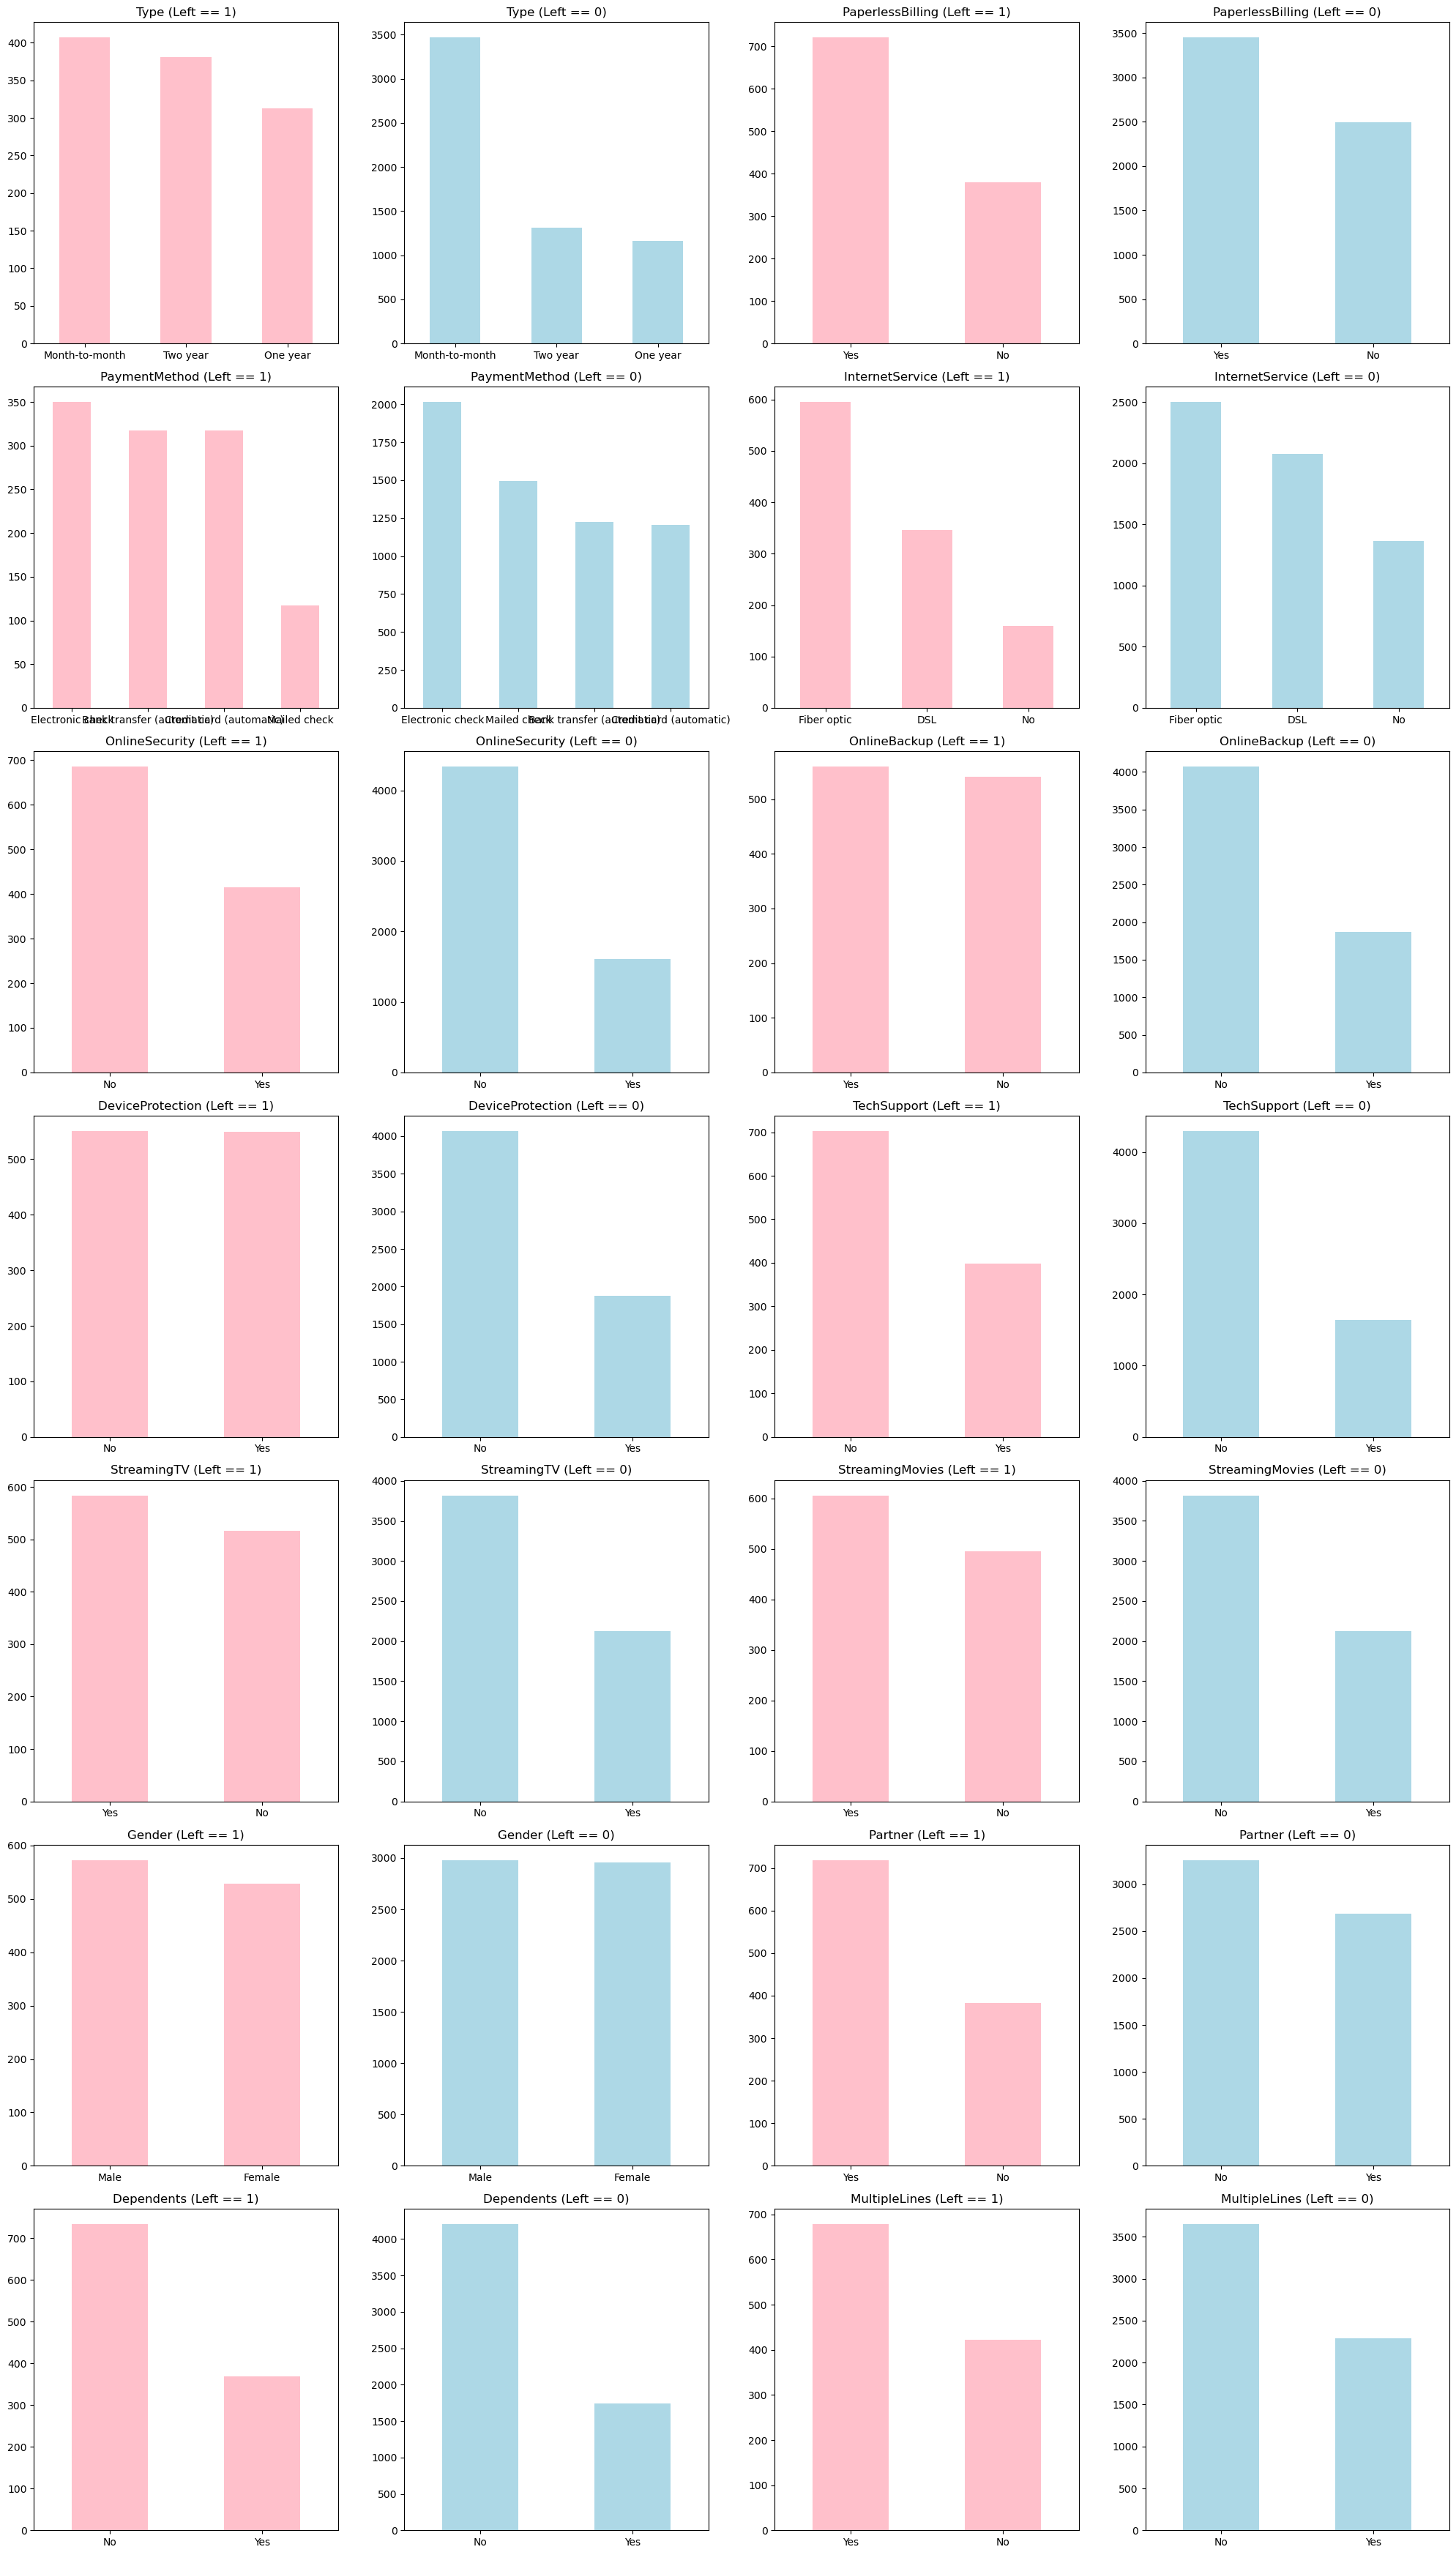

In [37]:
#Distribution of categorical features separately for churned and retained customers
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

cols = 2
rows = int(np.ceil(len(categorical_columns) / cols))

plt.figure(figsize=(20, 35))

for idx, column in enumerate(categorical_columns):
    ax = plt.subplot(rows, 2 * cols, idx * 2 + 1)
    
    data[data['Left'] == 1][column].value_counts().plot(
        kind='bar', 
        title=f'{column} (Left == 1)', 
        ax=ax,
        rot=0,
        color='pink'
    )
    
    ax = plt.subplot(rows, 2 * cols, idx * 2 + 2)
    data[data['Left'] == 0][column].value_counts().plot(
        kind='bar', 
        title=f'{column} (Left == 0)', 
        ax=ax,
        rot=0,
        color='lightblue'
    )

plt.tight_layout()
plt.show()

After analyzing the categorical features for the two groups of users, several observations can be made:

 - Churned users had contracts of all types, whereas the majority of retained users had mainly monthly contracts
 - Among the churned users, there were many with fiber optic internet
 - Many churned users were subscribed to additional services such as antivirus (DeviceProtection), cloud storage (OnlineBackup), streaming TV (StreamingTV), streaming movies (StreamingMovies), and multiple lines (MultipleLines)
 - Additionally, there were more married individuals among the churned users

It's possible to assume that the decision of users to leave might have been influenced by the quality of additional services and fiber optic internet.

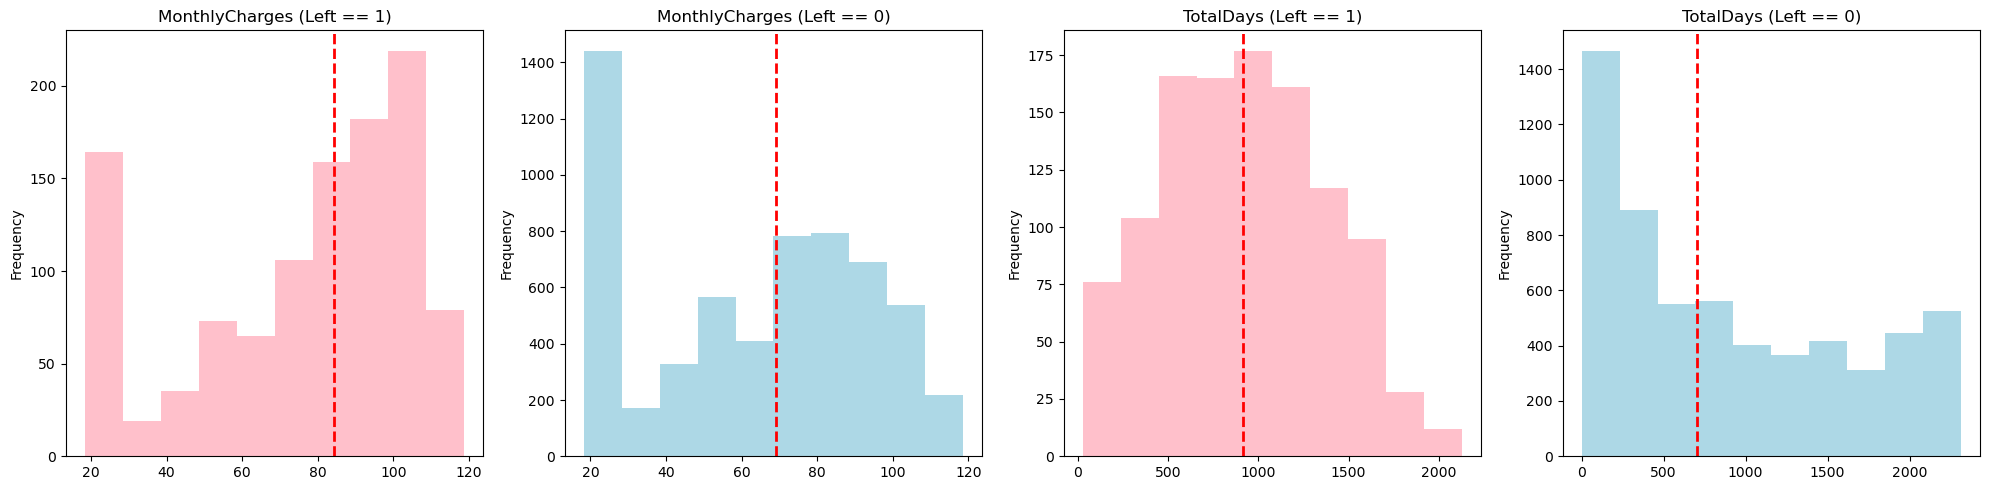

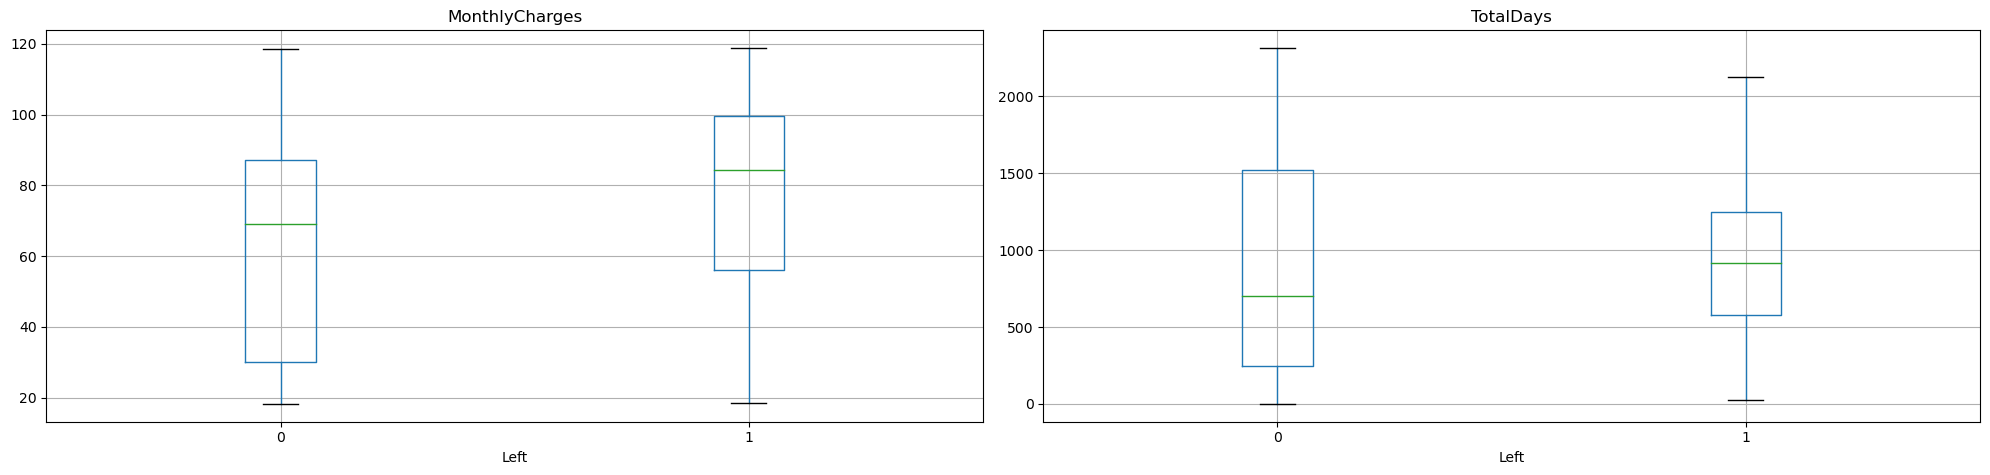

In [38]:
#Distribution of numeric features separately for churned and retained customers
numerical_columns = ['MonthlyCharges', 'TotalDays']

cols = 2
rows = int(np.ceil(len(numerical_columns) / cols))

plt.figure(figsize=(20, 5))

for idx, column in enumerate(numerical_columns):
    ax = plt.subplot(rows, 2 * cols, idx * 2 + 1)
    
    data[data['Left'] == 1][column].plot(
        kind='hist', 
        title=f'{column} (Left == 1)', 
        ax=ax,
        rot=0,
        color='pink'
    )
    plt.axvline(data[data['Left'] == 1][column].median(), color='red', linestyle='dashed', linewidth=2)
    
    ax = plt.subplot(rows, 2 * cols, idx * 2 + 2)
    data[data['Left'] == 0][column].plot(
        kind='hist', 
        title=f'{column} (Left == 0)', 
        ax=ax,
        rot=0,
        color='lightblue'
    )
    plt.axvline(data[data['Left'] == 0][column].median(), color='red', linestyle='dashed', linewidth=2)

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 5))
for idx, column in enumerate(numerical_columns):
    ax = plt.subplot(rows, cols, idx + 1)  
    data.boxplot(column=column, by='Left', ax=ax)
    plt.title(f'{column}')
    plt.suptitle('')  

plt.tight_layout()
plt.show()

By comparing churned and retained customers, the following observations can be made:

 - The company lost long-term customers (on average around 900 days) who were paying nearly 80 euros per month
 - The retained customers have been with the company for about 600 days on average and paid around 70 euros per month

Thus, the customers who had been using the services for a longer time and were paying more on average were the ones who chose to discontinue the services.

## Model training

In [39]:
#Spliting the dataset into training and testing sets
features = data.drop(['Left'], axis=1)
target = data['Left']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

print('Train set: ', features_train.shape[0] / features.shape[0] * 100)
print('Testing set: ', features_test.shape[0] / features.shape[0] * 100)

Train set:  74.99645037626011
Testing set:  25.003549623739886


In [40]:
#Categorical features
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Gender', 'Partner', 'Dependents', 'MultipleLines']


In [41]:
#Numeric features
#'SeniorCitizen' is a categorical binary feature, so let's remove it from the list
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('SeniorCitizen')
num_features

['MonthlyCharges', 'TotalDays']

In [42]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [43]:
#Encoding and scaling the data
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features_train_ohe[ohe_features])

features_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ohe[ohe_features])

features_train_ohe = features_train_ohe.drop(ohe_features, axis=1)

scaler = StandardScaler()

features_train_ohe[num_features] = scaler.fit_transform(features_train_ohe[num_features])

features_train_ohe.head()

,MonthlyCharges,SeniorCitizen,TotalDays,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes
CustomerID,,,,,,,,,,,,,,,,,,,,,
2675-IJRGJ,-1.495365,0,1.030452,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2988-PLAHS,0.177624,0,-1.185137,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
9489-JMTTN,0.836176,0,1.870396,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
7435-ZNUYY,-1.463768,0,-1.051212,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8562-GHPPI,-1.490376,0,-1.273935,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
features_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ohe [ohe_features])

features_test_ohe = features_test_ohe.drop(ohe_features, axis=1)

features_test_ohe[num_features] = scaler.transform(features_test_ohe[num_features])

features_test_ohe.head()

,MonthlyCharges,SeniorCitizen,TotalDays,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes
CustomerID,,,,,,,,,,,,,,,,,,,,,
6838-HVLXG,-1.473746,0,-0.787729,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3776-EKTKM,-0.936593,1,-1.096339,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0570-BFQHT,0.530182,0,-0.917287,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0203-HHYIJ,-1.307445,0,-0.033671,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
0404-SWRVG,0.325632,0,-1.096339,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


#### Logistical regression

In [45]:
parameters_log = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [100, 200, 500]
}

model_log = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=RANDOM_STATE)

gs_log = GridSearchCV(model_log, parameters_log, cv=5, scoring='roc_auc')
gs_log.fit(features_train_ohe, target_train)

print(f'AUC-ROC is: {gs_log.best_score_}')
print(f'The best parameters: {gs_log.best_params_}')

AUC-ROC is: 0.7593258186151808
The best parameters: {'C': 10, 'max_iter': 100}


#### Decision tree

In [46]:
pipeline_tree = Pipeline(
    [('dtree', DecisionTreeClassifier(random_state=RANDOM_STATE))])

parameters_tree = {
    'dtree__max_depth': range(2, 15),
    'dtree__min_samples_split': [2, 3, 4],
    'dtree__min_samples_leaf': [1, 2, 3, 4]
}

gs_tree = RandomizedSearchCV(pipeline_tree, parameters_tree, cv=3, n_jobs=-1, scoring='roc_auc')
gs_tree.fit(features_train_ohe, target_train)
predicted_probalities_tree = gs_tree.best_estimator_.predict_proba(features_test_ohe)[:, 1]

print(f'AUC-ROC is: {gs_tree.best_score_}')
print(f'The best parameters: {gs_tree.best_params_}')

AUC-ROC is: 0.7641379936452583
The best parameters: {'dtree__min_samples_split': 4, 'dtree__min_samples_leaf': 3, 'dtree__max_depth': 5}


#### Random forest

In [47]:
pipeline_forest = Pipeline(
    [('dforest', RandomForestClassifier(random_state=RANDOM_STATE, verbose=0))])

parameters_forest = {
    'dforest__n_estimators': range(50, 251, 50),
    'dforest__max_depth': range(2, 15),
    'dforest__min_samples_split': (2, 3, 4),
    'dforest__min_samples_leaf': (1, 2, 3, 4)
}

gs_forest = RandomizedSearchCV(pipeline_forest, parameters_forest, cv=3, n_jobs=-1, scoring='roc_auc')
gs_forest.fit(features_train_ohe, target_train)

print(f'AUC-ROC is: {gs_forest.best_score_}')
print(f'The best parameters: {gs_forest.best_params_}')

AUC-ROC is: 0.8173309469498969
The best parameters: {'dforest__n_estimators': 200, 'dforest__min_samples_split': 2, 'dforest__min_samples_leaf': 2, 'dforest__max_depth': 10}


#### CatBoostClassifier

In [48]:
pipeline_catboost = Pipeline(
    [('dcat', CatBoostClassifier(random_state=RANDOM_STATE, verbose=False))])

parameters_catboost = {
    'dcat__iterations': np.arange(100, 1000, 100),  
    'dcat__learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'dcat__depth': np.arange(3, 11),  
    'dcat__l2_leaf_reg': [1, 3, 5, 7], 
}

gs_catboost = RandomizedSearchCV(pipeline_catboost, parameters_catboost, cv=3, n_jobs=-1, scoring='roc_auc', verbose=3)
gs_catboost.fit(features_train_ohe, target_train)

print(f'AUC-ROC is: {gs_catboost.best_score_}')
print(f'The best parameters: {gs_catboost.best_params_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
AUC-ROC is: 0.921823154822309
The best parameters: {'dcat__learning_rate': 0.2, 'dcat__l2_leaf_reg': 7, 'dcat__iterations': 900, 'dcat__depth': 3}


In [49]:
results = pd.DataFrame(
    [gs_log.best_score_, 
     gs_tree.best_score_, 
     gs_forest.best_score_, 
     gs_catboost.best_score_], 
    index=['Logistical regression', 'Decision tree', 'Random Forest', 'CatBoostClassifier'], 
    columns=['ROC-AUC']
)
results

,ROC-AUC
Logistical regression,0.759326
Decision tree,0.764138
Random Forest,0.817331
CatBoostClassifier,0.921823


The best result was achieved by the CatBoostClassifier model (0.921), which surpasses the specified threshold of 0.85. Let's now examine which features played the most significant roles during the training.

In [50]:
importance = pd.DataFrame(gs_catboost.best_estimator_.named_steps['dcat'].feature_importances_, 
                          index = features_train_ohe.columns, columns=['Importance'])
importance = importance.sort_values(by='Importance', ascending=False)
importance

,Importance
TotalDays,62.357117
MonthlyCharges,15.261575
Type_Two year,3.611208
Partner_Yes,2.814185
PaymentMethod_Mailed check,2.162777
MultipleLines_Yes,1.895848
OnlineBackup_Yes,1.666611
Type_One year,1.665229
Dependents_Yes,1.129833
TechSupport_Yes,1.064653


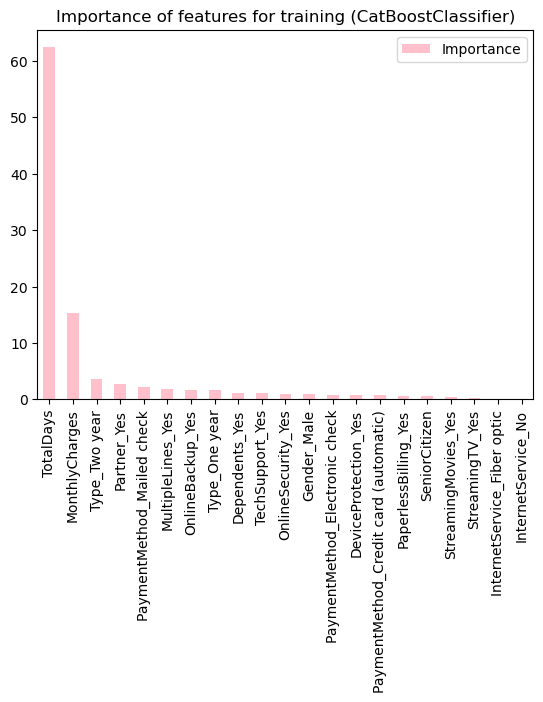

In [51]:
importance.plot(kind='bar', color='pink', title='Importance of features for training (CatBoostClassifier)')
plt.show()

The most important features appeared to be TotalDays, MonthlyCharges, Type(Two year) и Partner(Yes).

In [52]:
#Cheking the model on the test set
catboost_pred = gs_catboost.predict_proba(features_test_ohe)[:, 1]

roc_auc_test = roc_auc_score(target_test, catboost_pred)
print(f'ROC-AUC on the test dataset: {roc_auc_test}')

ROC-AUC on the test dataset: 0.933772262722186


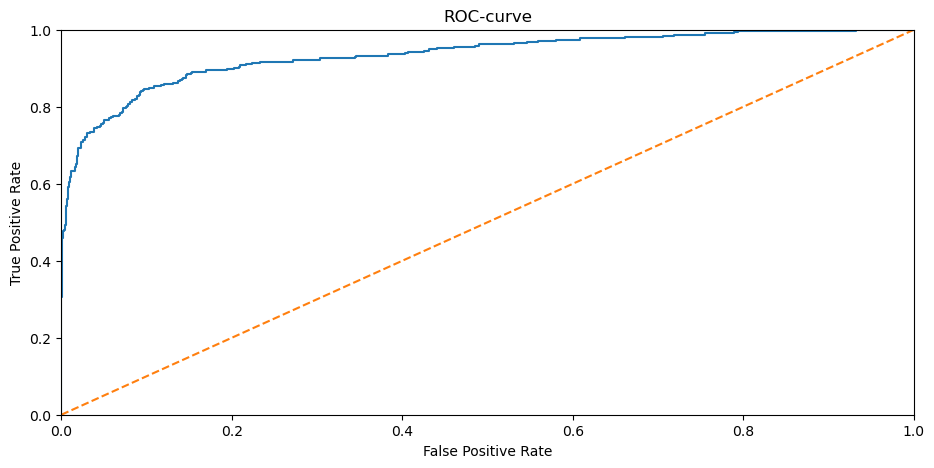

In [53]:
#Plotting the ROC-curve
fpr, tpr, thresholds = roc_curve(target_test, catboost_pred)

plt.figure(figsize=(11, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
plt.title('ROC-curve')  
plt.show()

The model has demonstrated a good result on the test dataset (0.933), indicating that it accurately predicts the likelihood of customer churn.

In [54]:
threshold = 0.5
catboost_pred_binary = np.where(catboost_pred > threshold, 1, 0)

accuracy = accuracy_score(target_test, catboost_pred_binary)
print(f'The accuracy of the model on the test dataset is {accuracy}')

The accuracy of the model on the test dataset is 0.9222032935831914


In [55]:
matrix = confusion_matrix(target_test, catboost_pred_binary)

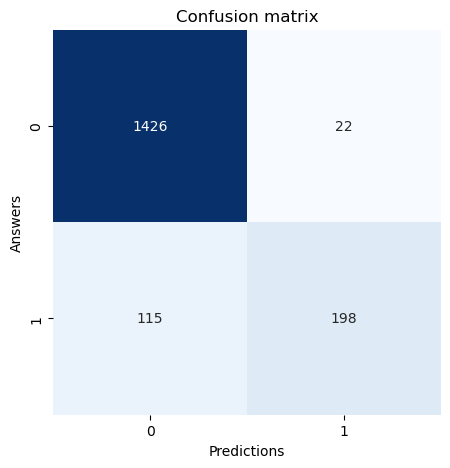

In [56]:
plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predictions')
plt.ylabel('Answers')
plt.title('Confusion matrix')
plt.show()

In [57]:
catboost_pred = gs_catboost.predict_proba(features_test_ohe)[:, 1]

test_pool = Pool(features_test_ohe, label=target_test)
feature_importances_test = gs_catboost.best_estimator_.named_steps['dcat'].get_feature_importance(data=test_pool, type="LossFunctionChange")

importance_test = pd.DataFrame({'Feature': features_test_ohe.columns, 'Importance': feature_importances_test})
importance_test = importance_test.sort_values(by='Importance', ascending=False)
importance_test = importance_test.set_index('Feature')

importance_test

,Importance
Feature,
TotalDays,0.267806
Partner_Yes,0.009033
Type_Two year,0.008827
Type_One year,0.007396
MultipleLines_Yes,0.005674
StreamingMovies_Yes,0.003965
PaymentMethod_Mailed check,0.001869
OnlineBackup_Yes,0.000922
DeviceProtection_Yes,0.000824


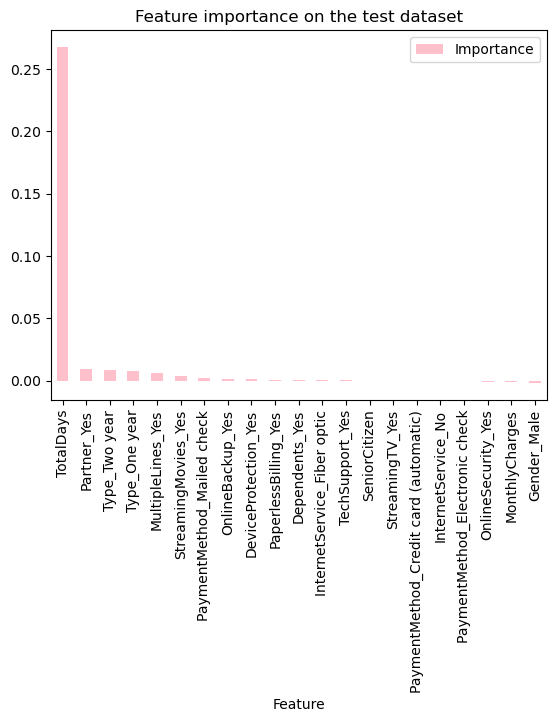

In [58]:
importance_test.plot(kind='bar', color='pink', title='Feature importance on the test dataset')
plt.show()

For the test dataset, the most influential features were TotalDays, Partner_Yes, MultipleLines_Yes, Type_One_year, and Type_Two_Year, while the rest did not play a significant role.

## Conclusion

The objective of the analysis was to train a model capable of predicting customer churn for a telecommunications company. Four datasets containing user data were provided.

During the preliminary data analysis, the tables were merged, missing values were handled, a new feature "TotalDays" was created, and two date-related features were removed.

Next, the correlation and significance of features were explored, along with the dynamics of features for churned and retained customers. It was demonstrated that customers who left the company had been using the services for an extended period and were paying around 80 euros per month. Possible reasons for customer churn included dissatisfaction with additional services and the quality of fiber optic internet.

Subsequently, four models were trained: Logistic regression, Decision tree, Random forest, and CatBoostClassifier. Ultimately, the best AUC-ROC result was achieved by the CatBoostClassifier with 0.921 on the training set and 0.933 on the test set, indicating that the model performs well in recognition and can be applied to the task.

The most significant features for model training were the number of days of service usage, monthly payment, contract type, and partner presence. On the test set, the most important feature remained the number of days.

## Solution report

The goal of the project was to train a model capable of predicting potential customer churn in a telecommunications company, with the AUC-ROC metric required to be above 0.85.

The company provides services for telephone communication, internet, and additional services related to the internet (such as antivirus, unsafe website blocking, dedicated technical support line, cloud file storage for data backup, streaming television, and a movie catalog).

For the analysis, the company provided four datasets:

 - contract_new.csv — contract information
 - personal_new.csv — customer personal data
 - internet_new.csv — information about internet services
 - phone_new.csv — information about phone services

All files included the customer code (column: customerID). The information was extracted on February 1, 2020.

The analysis was conducted in four main steps:

 1) Preliminary Data Analysis
 2) Data Preprocessing
 3) Data Analysis
 4) Model Training and Evaluation

#### Preliminary Data Analysis
First, the datasets were loaded, and information about them was examined. The data types of features "TotalCharges" (converted to numeric) and "BeginDate" (converted to date) were adjusted, and missing values arising from these adjustments were handled.

Then, the tables were merged, resulting in the following features being identified in the data:

 - BeginDate – start date of service usage
 - EndDate – end date of service usage
 - Type – payment type: monthly, yearly, two-year
 - PaperlessBilling – electronic payment document
 - PaymentMethod – payment method: electronic check, mailed check, bank transfer, credit card
 - MonthlyCharges – monthly expenditure on services
 - TotalCharges – total money spent on services
 - InternetService - type of internet: DSL, fiber optic, or None
 - DeviceProtection - antivirus service
 - OnlineSecurity - online security service
 - TechSupport - dedicated technical support service
 - OnlineBackup - cloud file storage for data backup
 - StreamingTV - streaming television service
 - StreamingMovies - streaming movie service
 - Gender - user's gender
 - Dependents – presence of dependents
 - Senior Citizen – senior citizen status
 - Partner – presence of a partner
 - MultipleLines – availability of multiple lines during calls

#### Data Preprocessing

After merging the tables, 1526 missing values appeared in the features "InternetService", additional services, and "MultipleLines" for users without internet connection. These gaps were filled with "No".

Moreover, new features "TotalDays" (total number of days using the company's services) and "Left" (whether the customer left or not) were created. To avoid data leakage, the "BeginDate" and "EndDate" features were removed.

#### Data Analysis

Next, correlation and statistical significance matrices of the features were generated. The matrices revealed high correlations between "TotalDays" and "TotalCharges", "TotalCharges" and "MonthlyCharges", and correlations between additional services. To reduce multicollinearity, the "TotalCharges" feature was ultimately removed. Analysis of statistical significance indicated that the "Gender" feature would not play a significant role in model training.

Distribution of categorical and numerical features was examined separately and based on the target feature.

As a result of the analysis, the following conclusions were drawn:

 - Churned customers had contracts of all types, whereas retained customers were mainly on monthly contracts.
 - Among the churned customers, many had fiber optic internet.
 - Many churned customers were subscribed to additional services: antivirus (DeviceProtection), cloud storage (OnlineBackup), streaming TV (StreamingTV), streaming movies (StreamingMovies), and multiple lines (MultipleLines).
 - The company lost long-term customers (900 days on average).
 - Churned customers paid about 10 euros more for services than retained customers.

Thus, it was hypothesized that the decision of customers to churn was influenced by service pricing, the quality of fiber optic internet, and the quality of additional services.

#### Model Training and Evaluation

After analysis, the data was split into training and test sets in a 75%-25% ratio, categorical features were encoded, and numerical features were scaled.

Subsequently, four models were trained: logistic regression, decision tree, random forest, and CatBoostClassifier.

The CatBoostClassifier demonstrated the best result: ROC-AUC of 0.921 on the training set and 0.933 on the test set. The model's hyperparameters were defined as follows:

 - learning_rate: 0.1
 - l2_leaf_reg': 1
 - iterations': 600
 - depth: 6
 - RANDOM_STATE: 100723

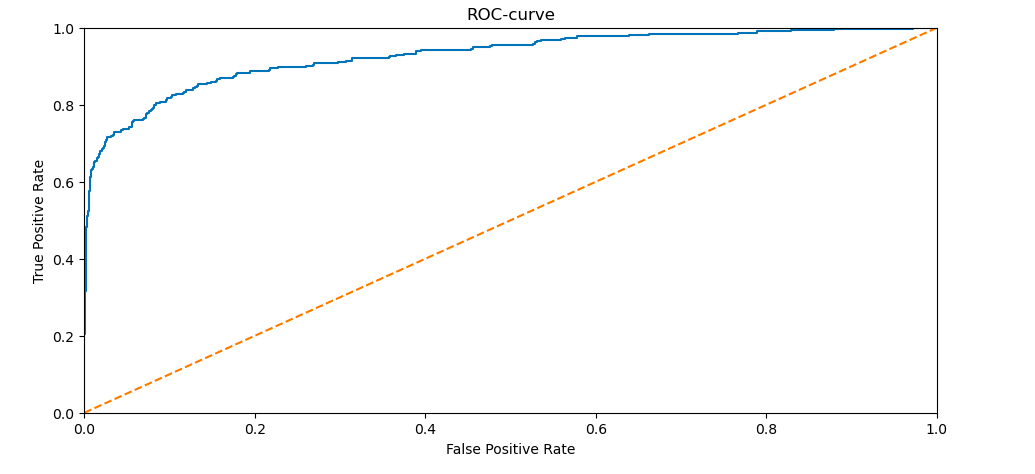

Feature importance was studied during training, with the most important features being "TotalDays", "MonthlyCharges", "Type" (Two year), and "Partner" (Yes). For the test dataset, the significant features were "TotalDays", "Partner" (Yes), "MultipleLines" (Yes), "Type" (One year), and "Type" (Two year).
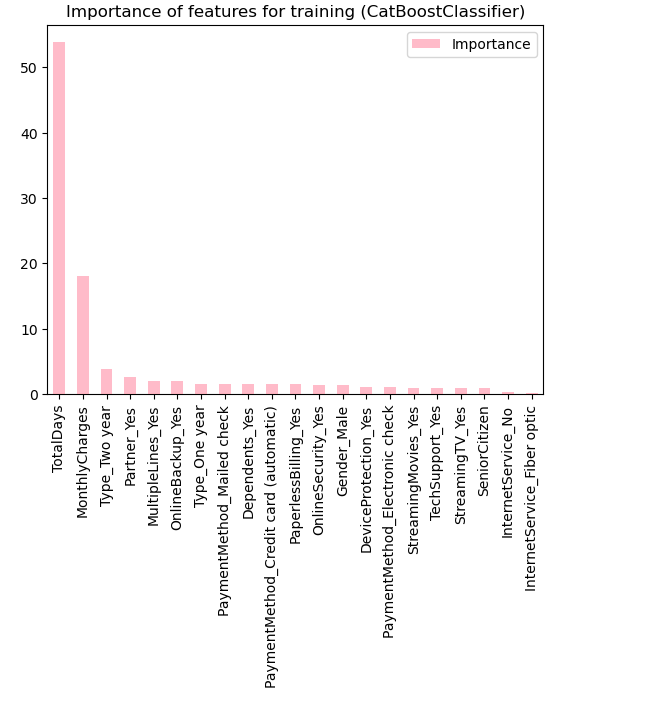
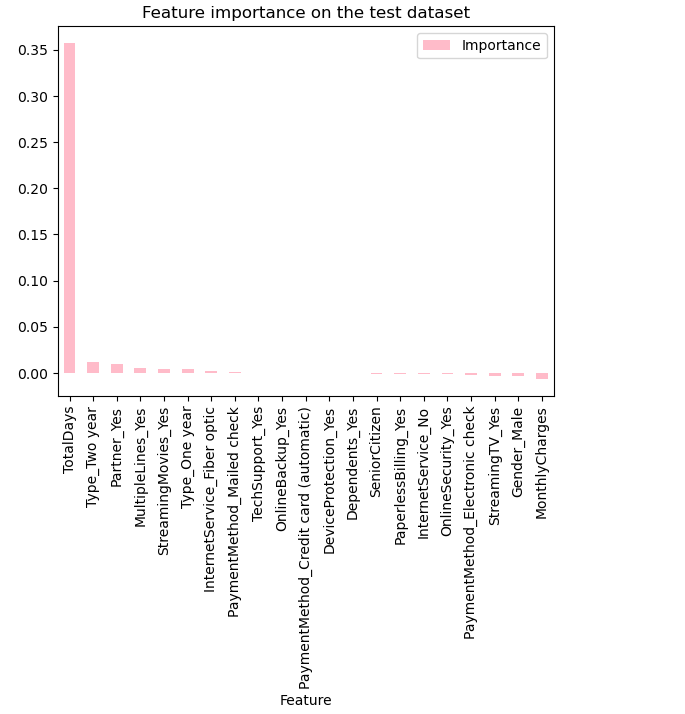

A confusion matrix was also obtained during analysis, indicating that the model frequently predicts correctly when a customer does not churn.

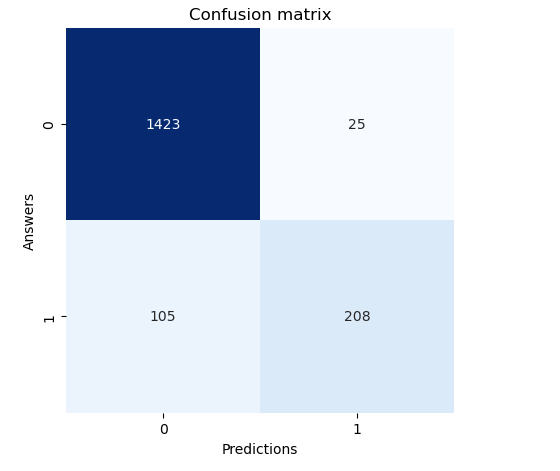

In conclusion, the assignment's goal was achieved: the model performed above the specified threshold and can be applied for identifying potential churn customers.

All steps outlined at the beginning were successfully executed. The main challenge was selecting features for model training, where some features were not suitable for training (BeginDate, EndDate, TotalCharges, CategoryID), and some had to be created manually (TotalDays, Left).